# Modeling

The goal of this model is to generate a list of potential cities, companies, and job titles fitting my desired salary range and perceived competitiveness in the job market.

Inputs: a desired salary range, and self perceived competitiveness in the job market

Outputs: cities and companies to look at applying to, alongside with job titles

Dataframe Modelling Features: upper salary offer, lower salary offer, company rating, total data science related positions in the state of company in 2023, ratio of new postings in state to total data science positions, annual mean and median wage of data science professionals in company's state, and ratio of jobs offering pay to state's mean and median wages.


Using a dataset detailing the job postings within the data science market in 2024 (https://www.kaggle.com/datasets/ritiksharma07/data-science-job-listings-from-glassdoor) and a dataset from the Bureau of labor statistics on data science salary and employment stats in 2023 (https://data.bls.gov/oes/#/occInd/One%20occupation%20for%20multiple%20industries), I was able to construct a dataframe with several hundred jobs posted, their upper and lower salaries in pay, the company rating, the amount of data science related positions that are within the state of the job, the annual mean wage of data science related professionals in the company's state, the median wage of data science related professional in the company's state, the ratio of the jobs pay to to the state mean and median, and the relative ratio of new data science job postings to total positions already in the state.  The jobs were labelled according to which region of the country that are in; the region being symbolic of the economy there.

Using these numerical features, I was able to test out three classification models: random forest classification, K neighbors classifications, and gradient boosting classifications.  The random forest and gradient boosting classifiers were able to perform the best as far as accuracy and F1 scores go, so those two hyper parameter tuned models will be used in this modelling.

The model will be inserted into a function that will take into account, the salary range and perceived competitiveness (perceived competitiveness is best explained as: if you gave your self a 1.1 that means that you believe you deserve pay above the average/median pay of data science related professionals of the region; conversely a rating of .8 would indicate that you believe you deserve pay below the average/median pay of data science related professionals of the region).

The previous installments in this projects progression can be found in these links:
https://github.com/gisthuband/Capstone_2_DS_Job_Locator/blob/main/data_wrangle.ipynb https://github.com/gisthuband/Capstone_2_DS_Job_Locator/blob/main/exploratory_data_analysis.ipynb
https://github.com/gisthuband/Capstone_2_DS_Job_Locator/blob/main/preprocessing%20and%20model%20training.ipynb




This notebook will contain the following:

1.) Modeling and prediction with the hyperparameter tuned random forest classifier

2.) Modeling and prediction with the hyperparameter tuned gradient boosted classifier

3.) Modeling and prediction with the hyperparameter tuned deep neural network classifier

# Imports and Dataframe Upload

In [1]:
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn import metrics
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
df = pd.read_csv('explored_data_v1.csv')

df = df.drop(columns='Unnamed: 0')

df.head()

,upper_salary,lower_salary,state,city,Job Title,Company Rating,company_name,tot_employment_in_state,Annual mean wage(2),Annual median wage(2),total_new_post_rat,range_avg_to_mean_ratio,range_avg_to_median_ratio,labels
0,84000.000000,57000.000000,WI,Onalaska,Associate Stop Loss Underwriter,2.7,The Insurance Center,3090.0,105250.0,101850.0,515.0,0.669834,0.692194,midwest
1,148165.491991,104355.331808,WI,Eau Claire,Marketing Advertising Analyst,3.0,"Net Health Shops, LLC",3090.0,105250.0,101850.0,515.0,1.199624,1.239670,midwest
2,160000.000000,135000.000000,WI,Madison,Manager - IT Infrastructure Engineering,3.9,UW Credit Union,3090.0,105250.0,101850.0,515.0,1.401425,1.448208,midwest
3,84000.000000,59000.000000,WI,Wausau,Associate Stop Loss Underwriter,2.7,The Insurance Center,3090.0,105250.0,101850.0,515.0,0.679335,0.702013,midwest
4,87000.000000,58000.000000,WI,New Berlin,Supply Chain Data Analyst (Day Shift) - New Be...,3.5,DB SCHENKER,3090.0,105250.0,101850.0,515.0,0.688836,0.711831,midwest


Really quickly transfrom the total_new_post_ratio to reflect the self-perceived competitiveness aspect of the model

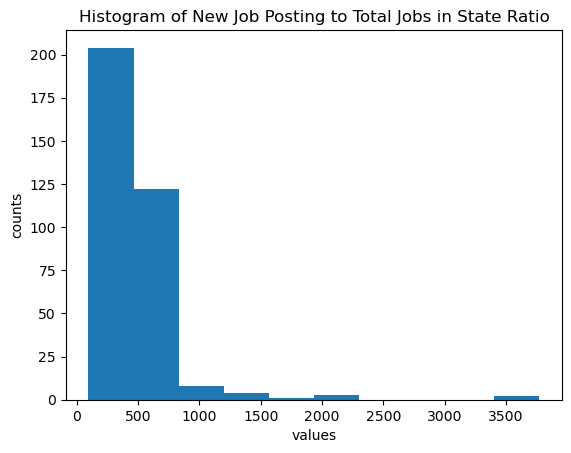

In [3]:
plt.hist(df['total_new_post_rat'])
plt.xlabel('values')
plt.ylabel('counts')
plt.title('Histogram of New Job Posting to Total Jobs in State Ratio')
plt.show()

with an inverse transformation, now the distribution is more gaussian, and inverted, so a smaller value will now mean that the state has a more competitive entry into the field, and the larger values will now mean that the state has an easier entry into the job market

As a user, the perceived competitiveness will have 1 subtracted from it, and the difference will be multplied by the std of the this distribution, and this number will be subtracted from the median

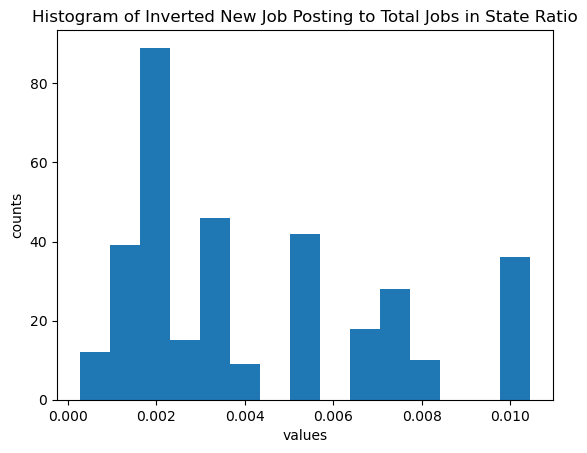

In [4]:
new_ser = 1/df['total_new_post_rat']
plt.hist(new_ser, bins=15)
plt.xlabel('values')
plt.ylabel('counts')
plt.title('Histogram of Inverted New Job Posting to Total Jobs in State Ratio')
plt.show()

In [5]:
df = df.drop(columns='total_new_post_rat')
df = pd.concat([df,new_ser], axis=1)

In [6]:
df.head()

,upper_salary,lower_salary,state,city,Job Title,Company Rating,company_name,tot_employment_in_state,Annual mean wage(2),Annual median wage(2),range_avg_to_mean_ratio,range_avg_to_median_ratio,labels,total_new_post_rat
0,84000.000000,57000.000000,WI,Onalaska,Associate Stop Loss Underwriter,2.7,The Insurance Center,3090.0,105250.0,101850.0,0.669834,0.692194,midwest,0.001942
1,148165.491991,104355.331808,WI,Eau Claire,Marketing Advertising Analyst,3.0,"Net Health Shops, LLC",3090.0,105250.0,101850.0,1.199624,1.239670,midwest,0.001942
2,160000.000000,135000.000000,WI,Madison,Manager - IT Infrastructure Engineering,3.9,UW Credit Union,3090.0,105250.0,101850.0,1.401425,1.448208,midwest,0.001942
3,84000.000000,59000.000000,WI,Wausau,Associate Stop Loss Underwriter,2.7,The Insurance Center,3090.0,105250.0,101850.0,0.679335,0.702013,midwest,0.001942
4,87000.000000,58000.000000,WI,New Berlin,Supply Chain Data Analyst (Day Shift) - New Be...,3.5,DB SCHENKER,3090.0,105250.0,101850.0,0.688836,0.711831,midwest,0.001942


## Random Forest Classifier

In [7]:
def rfc_salary_output(salary, low_salary, rat , df):
    west_cit_list = [x for x in df.loc[df['labels']== 'west', 'city'].value_counts()[:7].index]
    east_cit_list = [x for x in df.loc[df['labels']== 'east', 'city'].value_counts()[:7].index]
    midwest_cit_list = [x for x in df.loc[df['labels']== 'midwest', 'city'].value_counts()[:7].index]
    south_cit_list = [x for x in df.loc[df['labels']== 'south', 'city'].value_counts()[:7].index]
    
    
    west_comp_list = [x for x in df.loc[df['labels']== 'west', 'company_name'].value_counts()[:7].index]
    east_comp_list = [x for x in df.loc[df['labels']== 'east', 'company_name'].value_counts()[:7].index]
    midwest_comp_list = [x for x in df.loc[df['labels']== 'midwest', 'company_name'].value_counts()[:7].index]
    south_comp_list = [x for x in df.loc[df['labels']== 'south', 'company_name'].value_counts()[:7].index]
    remote_comp_list = [x for x in df.loc[df['labels']== 'remote', 'company_name'].value_counts()[:7].index]
    
    west_job_list = [x for x in df.loc[df['labels']== 'west', 'Job Title'].value_counts()[:10].index]
    east_job_list = [x for x in df.loc[df['labels']== 'east', 'Job Title'].value_counts()[:10].index]
    midwest_job_list = [x for x in df.loc[df['labels']== 'midwest', 'Job Title'].value_counts()[:10].index]
    south_job_list = [x for x in df.loc[df['labels']== 'south', 'Job Title'].value_counts()[:10].index]
    remote_job_list = [x for x in df.loc[df['labels']== 'remote', 'Job Title'].value_counts()[:10].index]
    
    west = [west_cit_list, west_comp_list, west_job_list]
    east = [east_cit_list, east_comp_list, east_job_list]
    midwest = [midwest_cit_list, midwest_comp_list, midwest_job_list]
    south = [south_cit_list, south_comp_list, south_job_list]
    remote = [remote_comp_list, remote_job_list]
    
    
    
    
    df = df.drop(columns=['state','city','Job Title','company_name'])
    
    dum_df = pd.get_dummies(df['labels'])


    dummed_df = pd.concat([df, dum_df],axis=1)

    dummed_df = dummed_df.drop(columns='labels')


    features = list(dummed_df.columns[dummed_df.columns != 'west'])
    features.remove('south')
    features.remove('east')
    features.remove('midwest')
    features.remove('remote')

    X = dummed_df[features]

    y = dummed_df[['west','east','south','midwest','remote']]

    
    RFC = RandomForestClassifier(n_estimators=500, criterion='entropy')
    res = RFC.fit(X, y)
    
    avg_diff = (np.mean(X['upper_salary'])-np.mean(X['lower_salary']))
    
    lower_gen = low_salary
    
    tot_emp_gen = np.median(X['tot_employment_in_state'])

    tot_post_gen = np.median(X['total_new_post_rat'])-5.2*(rat-1)*np.std(X['total_new_post_rat'])
    #5.2 reflects how many time the self perceived confidence number range(.5 - 1.5) can go into 2.6 (which is the number of standard deviations containing the majority of the data points)

    avg_mean_rat_gen = rat
    
    avg_median_rat_gen = rat - (np.mean(X['range_avg_to_mean_ratio'])-np.mean(X['range_avg_to_median_ratio']))
    
    ann_mean_gen = (lower_gen + avg_diff/2)* avg_mean_rat_gen
    
    ann_med_gen = (lower_gen + avg_diff/2)* avg_median_rat_gen
    
    comp_rate_gen = np.median(X['Company Rating'])
    
    sal_x = [salary, lower_gen, comp_rate_gen, tot_emp_gen, ann_mean_gen, ann_med_gen, tot_post_gen, avg_mean_rat_gen, avg_median_rat_gen]

    sal_x = np.array(sal_x)
    sal_x = sal_x.reshape(1,-1)

    y_pred = res.predict(sal_x)
    
    y_prob = res.predict_proba(sal_x)
    print (y_prob)
    
    y_list = []
    for x in y_pred:
        for y in x:
            y_list.append(y)
            
    if y_list == [1, 0, 0 ,0 ,0]:
        return (f'best cities to look at: {[x for x in west[0]]}. best companies to look for: {[x for x in west[1]]}. job titles to look for:{[x for x in west[2]]}')
    elif y_list == [0, 1, 0, 0 ,0]:
        return (f'best cities to look at: {[x for x in east[0]]}. best companies to look for: {[x for x in east[1]]}. job titles to look for:{[x for x in east[2]]}')
    elif y_list == [0, 0, 1, 0 ,0]:
        return (f'best cities to look at: {[x for x in south[0]]}. best companies to look for: {[x for x in south[1]]}. job titles to look for:{[x for x in south[2]]}')
    elif y_list == [0, 0, 0, 1 ,0]:
        return (f'best cities to look at: {[x for x in midwest[0]]}. best companies to look for: {[x for x in midwest[1]]}. job titles to look for:{[x for x in midwest[2]]}')
    elif y_list == [0, 0, 0, 0 ,1]:
        return (f'you should look remote, best companies to look for: {[x for x in remote[0]]}. job titles to look for:{[x for x in remote[1]]}')
    else:
        ('readjust query')
        
        
    
   
    
    
    
    
    

In [8]:
rfc_trial = rfc_salary_output(130000, 110000, .8, df)

[array([[0.944, 0.056]]), array([[0.908, 0.092]]), array([[0.898, 0.102]]), array([[0.816, 0.184]]), array([[0.434, 0.566]])]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


There is a 57% probability that the classification is Remote, which is above the percentages for others (6%, 10%, 18%, 43%)

In [10]:
print (rfc_trial)

you should look remote, best companies to look for: ['Insurity', 'Inizio Engage', 'G2i Inc', 'Confidential', 'Ami Arroyo, Inc.', 'Solytics Partners LLC', 'Illumination Works']. job titles to look for:['Senior Data Scientist', 'Data Scientist', 'Data Science Technical Fellow', 'Senior Data Engineer (Machine Learning)', 'Business Analyst/Agilist', 'Data Scientist (Javascript, .Net Framework, SQL)-Remote', 'Medical Information Specialist III', 'Senior Financial Data Analyst - Work Comp Claims', 'Manager, Data Science Platform Engineering', 'Director of Data Science']


## Gradient Boosting Classifier

In [11]:
def gb_salary_output(salary, low_salary, rat , df):
    west_cit_list = [x for x in df.loc[df['labels']== 'west', 'city'].value_counts()[:7].index]
    east_cit_list = [x for x in df.loc[df['labels']== 'east', 'city'].value_counts()[:7].index]
    midwest_cit_list = [x for x in df.loc[df['labels']== 'midwest', 'city'].value_counts()[:7].index]
    south_cit_list = [x for x in df.loc[df['labels']== 'south', 'city'].value_counts()[:7].index]
    
    
    west_comp_list = [x for x in df.loc[df['labels']== 'west', 'company_name'].value_counts()[:7].index]
    east_comp_list = [x for x in df.loc[df['labels']== 'east', 'company_name'].value_counts()[:7].index]
    midwest_comp_list = [x for x in df.loc[df['labels']== 'midwest', 'company_name'].value_counts()[:7].index]
    south_comp_list = [x for x in df.loc[df['labels']== 'south', 'company_name'].value_counts()[:7].index]
    remote_comp_list = [x for x in df.loc[df['labels']== 'remote', 'company_name'].value_counts()[:7].index]
    
    west_job_list = [x for x in df.loc[df['labels']== 'west', 'Job Title'].value_counts()[:10].index]
    east_job_list = [x for x in df.loc[df['labels']== 'east', 'Job Title'].value_counts()[:10].index]
    midwest_job_list = [x for x in df.loc[df['labels']== 'midwest', 'Job Title'].value_counts()[:10].index]
    south_job_list = [x for x in df.loc[df['labels']== 'south', 'Job Title'].value_counts()[:10].index]
    remote_job_list = [x for x in df.loc[df['labels']== 'remote', 'Job Title'].value_counts()[:10].index]
    
    west = [west_cit_list, west_comp_list, west_job_list]
    east = [east_cit_list, east_comp_list, east_job_list]
    midwest = [midwest_cit_list, midwest_comp_list, midwest_job_list]
    south = [south_cit_list, south_comp_list, south_job_list]
    remote = [remote_comp_list, remote_job_list]
    
    
    
    
    df = df.drop(columns=['state','city','Job Title','company_name'])
    
    features = list(df.columns[df.columns != 'labels'])

    X = df[features]
    y = df['labels']


    
    GB = GradientBoostingClassifier(learning_rate=.75, max_depth=3, max_features=4, n_estimators=50)
    res = GB.fit(X, y)
    
    avg_diff = (np.mean(X['upper_salary'])-np.mean(X['lower_salary']))
    
    #lower_gen = salary - avg_diff
    lower_gen = low_salary
    
    tot_emp_gen = np.median(X['tot_employment_in_state'])
    
    tot_post_gen = np.median(X['total_new_post_rat'])-5.2*(rat-1)*np.std(X['total_new_post_rat'])
    #5.2 reflects how many time the self perceived confidence number range(.5 - 1.5) can go into 2.6 (which is the number of standard deviations containing the majority of the data points)
    avg_mean_rat_gen = rat
    
    avg_median_rat_gen = rat - (np.mean(X['range_avg_to_mean_ratio'])-np.mean(X['range_avg_to_median_ratio']))
    
    ann_mean_gen = (lower_gen + avg_diff/2)* avg_mean_rat_gen
    
    ann_med_gen = (lower_gen + avg_diff/2)* avg_median_rat_gen
    
    comp_rate_gen = np.median(X['Company Rating'])
    
    sal_x = [salary, lower_gen, comp_rate_gen, tot_emp_gen, ann_mean_gen, ann_med_gen, tot_post_gen, avg_mean_rat_gen, avg_median_rat_gen]

    sal_x = np.array(sal_x)
    sal_x = sal_x.reshape(1,-1)

    y_pred = res.predict(sal_x)
    print (y_pred)
    y_prob = res.predict_proba(sal_x)
    print (y_prob)
    
    y_list = []
    for x in y_pred:
        for y in x:
            y_list.append(y)
            
    if y_pred == ['west']:
        return (f'best cities to look at: {[x for x in west[0]]}. best companies to look for: {[x for x in west[1]]}. job titles to look for:{[x for x in west[2]]}')
    elif y_pred == ['east']:
        return (f'best cities to look at: {[x for x in east[0]]}. best companies to look for: {[x for x in east[1]]}. job titles to look for:{[x for x in east[2]]}')
    elif y_pred == ['south']:
        return (f'best cities to look at: {[x for x in south[0]]}. best companies to look for: {[x for x in south[1]]}. job titles to look for:{[x for x in south[2]]}')
    elif y_pred == ['midwest']:
        return (f'best cities to look at: {[x for x in midwest[0]]}. best companies to look for: {[x for x in midwest[1]]}. job titles to look for:{[x for x in midwest[2]]}')
    elif y_pred == ['remote']:
        return (f'you should look remote, best companies to look for: {[x for x in remote[0]]}. job titles to look for:{[x for x in remote[1]]}')
    else:
        ('readjust query')
        

In [12]:
gb_trial = gb_salary_output(130000, 110000, .8, df)

['midwest']
[[2.54670918e-06 9.83441363e-01 1.63790151e-02 1.77000513e-04
  7.50123121e-08]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


A 98% probability that the classification is the midwest region, with the probability of the classification being the others very low

In [13]:
print (gb_trial)

best cities to look at: ['Riverwoods', 'Chicago', 'Cincinnati', 'Minneapolis', 'Detroit', 'Columbus', 'Onalaska']. best companies to look for: ['Discover Financial Services', 'Inizio Engage', 'The Insurance Center', 'Home Chef', 'S&S Activewear LLC', 'NextGen Federal Systems', 'Gohagan & Company']. job titles to look for:['Associate Stop Loss Underwriter', 'Senior Data Scientist', 'Manager, Data Science (Remote)', 'Rapid Deployment Representative', 'Sr. Healthcare Data Analyst', 'Lead Data Science Analyst', 'Sr. Data Analyst, Finance', 'Modeler', 'Lead Data Science Analyst (multiple openings) - IHM', 'Data Engineers']


# Deep Neural Network

In [14]:
def dnn_salary_output(salary, low_salary, rat , df):
    west_cit_list = [x for x in df.loc[df['labels']== 'west', 'city'].value_counts()[:7].index]
    east_cit_list = [x for x in df.loc[df['labels']== 'east', 'city'].value_counts()[:7].index]
    midwest_cit_list = [x for x in df.loc[df['labels']== 'midwest', 'city'].value_counts()[:7].index]
    south_cit_list = [x for x in df.loc[df['labels']== 'south', 'city'].value_counts()[:7].index]
    
    
    west_comp_list = [x for x in df.loc[df['labels']== 'west', 'company_name'].value_counts()[:7].index]
    east_comp_list = [x for x in df.loc[df['labels']== 'east', 'company_name'].value_counts()[:7].index]
    midwest_comp_list = [x for x in df.loc[df['labels']== 'midwest', 'company_name'].value_counts()[:7].index]
    south_comp_list = [x for x in df.loc[df['labels']== 'south', 'company_name'].value_counts()[:7].index]
    remote_comp_list = [x for x in df.loc[df['labels']== 'remote', 'company_name'].value_counts()[:7].index]
    
    west_job_list = [x for x in df.loc[df['labels']== 'west', 'Job Title'].value_counts()[:10].index]
    east_job_list = [x for x in df.loc[df['labels']== 'east', 'Job Title'].value_counts()[:10].index]
    midwest_job_list = [x for x in df.loc[df['labels']== 'midwest', 'Job Title'].value_counts()[:10].index]
    south_job_list = [x for x in df.loc[df['labels']== 'south', 'Job Title'].value_counts()[:10].index]
    remote_job_list = [x for x in df.loc[df['labels']== 'remote', 'Job Title'].value_counts()[:10].index]
    
    west = [west_cit_list, west_comp_list, west_job_list]
    east = [east_cit_list, east_comp_list, east_job_list]
    midwest = [midwest_cit_list, midwest_comp_list, midwest_job_list]
    south = [south_cit_list, south_comp_list, south_job_list]
    remote = [remote_comp_list, remote_job_list]
    
    df = df.drop(columns=['state','city','Job Title','company_name'])
    
    dum_df = pd.get_dummies(df['labels'])


    dummed_df = pd.concat([df, dum_df],axis=1)

    dummed_df = dummed_df.drop(columns='labels')


    features = list(dummed_df.columns[dummed_df.columns != 'west'])
    features.remove('south')
    features.remove('east')
    features.remove('midwest')
    features.remove('remote')

    X = dummed_df[features]
    X_tens = tf.convert_to_tensor(X)
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(X_tens)


    y = dummed_df[['west','east','south','midwest','remote']]

    
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(5)
      ])

    model.compile(optimizer='adam',
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy', 'precision', 'recall'])
    
    
    res=model.fit(X_tens, y, epochs=150, validation_split=.2, batch_size=16, verbose=False)
    
    
    avg_diff = (np.mean(X['upper_salary'])-np.mean(X['lower_salary']))
    
    #lower_gen = salary - avg_diff
    lower_gen = low_salary
    
    tot_emp_gen = np.median(X['tot_employment_in_state'])
    
    tot_post_gen = np.median(X['total_new_post_rat'])-5.2*(rat-1)*np.std(X['total_new_post_rat'])
    
    avg_mean_rat_gen = rat
    
    avg_median_rat_gen = rat - (np.mean(X['range_avg_to_mean_ratio'])-np.mean(X['range_avg_to_median_ratio']))
    
    ann_mean_gen = (lower_gen + avg_diff/2)* avg_mean_rat_gen
    
    ann_med_gen = (lower_gen + avg_diff/2)* avg_median_rat_gen
    
    comp_rate_gen = np.median(X['Company Rating'])
    
    sal_x = [salary, lower_gen, comp_rate_gen, tot_emp_gen, ann_mean_gen, ann_med_gen, tot_post_gen, avg_mean_rat_gen, avg_median_rat_gen]
    sal_x = np.array(sal_x)
    sal_x = sal_x.reshape(1,-1)
    sal_x = tf.convert_to_tensor(sal_x)
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(sal_x)

    y_pred = model.predict(sal_x)
    print (y_pred)
    
    y_pred = np.array(y_pred).argmax(axis=1)

    y_pred = int(y_pred[0])
    
    
            
    if y_pred == 0:
        return (f'best cities to look at: {[x for x in west[0]]}. best companies to look for: {[x for x in west[1]]}. job titles to look for:{[x for x in west[2]]}')
    elif y_pred == 1:
        return (f'best cities to look at: {[x for x in east[0]]}. best companies to look for: {[x for x in east[1]]}. job titles to look for:{[x for x in east[2]]}')
    elif y_pred == 2:
        return (f'best cities to look at: {[x for x in south[0]]}. best companies to look for: {[x for x in south[1]]}. job titles to look for:{[x for x in south[2]]}')
    elif y_pred == 3:
        return (f'best cities to look at: {[x for x in midwest[0]]}. best companies to look for: {[x for x in midwest[1]]}. job titles to look for:{[x for x in midwest[2]]}')
    elif y_pred == 4:
        return (f'you should look remote, best companies to look for: {[x for x in remote[0]]}. job titles to look for:{[x for x in remote[1]]}')
    else:
        ('readjust query')

In [15]:
dnn_trial = dnn_salary_output(130000, 110000, .8, df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[-3685.1877 -2195.099    344.3083   454.3417  1251.9784]]


In [16]:
print (dnn_trial)

you should look remote, best companies to look for: ['Insurity', 'Inizio Engage', 'G2i Inc', 'Confidential', 'Ami Arroyo, Inc.', 'Solytics Partners LLC', 'Illumination Works']. job titles to look for:['Senior Data Scientist', 'Data Scientist', 'Data Science Technical Fellow', 'Senior Data Engineer (Machine Learning)', 'Business Analyst/Agilist', 'Data Scientist (Javascript, .Net Framework, SQL)-Remote', 'Medical Information Specialist III', 'Senior Financial Data Analyst - Work Comp Claims', 'Manager, Data Science Platform Engineering', 'Director of Data Science']


# Results:

The hyperparamter tuned gradient boosting model was able to classify my ideal economic region with much greater certainty than the random forest classifier and deep neural network (98% probability).  The gradient boosted classifier gave the prediction of the midwest region, the regions economy capturing my range (110000-130000) being appropriate for someone of my confidence (.8) in my competitiveness in the job market.  The job titles suggested were just the most abundant titles in the region, not reflecting all of the titles possible, but just something to search for.

The random forest classifier and deep neural network seemed more confused by this input than the gradient boosted model, as they both classified me as wanting a remote job.  However, their confidence in this answer was less than the gradient boosted's confidence.  Perhaps the gradient boosted classifier is over confidently because it is overfitted, most likely, more data is needed, and perhaps the algorithm of the gradient boosted should be tweaked

Still, this model will be very helpful to aspiring and current data scientists alike in their search for work that fulfills their economic plan.  People in the tech field have many different goals and aspirations, and for a lot they want to build up enough wealth to acheive their financial goals.  With a model like this, the financial goal can be put front and center in their job search.  This model is better than a simple salary query into the glassdoor's searchbar because it uses economical data that reflects how competitive the data scientist industry is in the region as captured by metrics such as mean and median wages of the region.  Information like that is not easily found through job posting sites like glassdoor.

In the future, to accomodate the popularity of the algorithm, it would probably be beneficial to understand why the neural network is performing so poorly in comparison, as it is also training on error like the gradient boosting classifier.  Further inspection of data is most likely necessary.  More data inclusion might be useful in the model making.  2024 is only halfway over, so more job posting will be making there way to glassdoor, also the BLS might be releasing new data on the Data Scientist field soon as well.  

Also it would probably be good to take this data and work on a separate model: am I being compensated fairly?
The model would look into the job links provided in the initial kaggle dataset, parse through the job description and pick up on details such as: years of experience, degrees, skills, etc. and with this information, assign the compensation as a label.  The user could input their degree, years of experience, and skills into the model, and their location, and see what compensation they should be receiving.  